In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
%matplotlib notebook
from scipy import *
import os
import pandas as pd

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import Dropout
from keras.utils import np_utils
from keras.layers import Flatten, GaussianNoise
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D, AveragePooling2D
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam, SGD
from keras.models import load_model
from keras import layers
from keras import regularizers

# $3\mu m$ sized particles

In [2]:
# Data folder directory
exp_data_dir = "../../Data/1st article data/Synthetic particles/"

# number of bins
P = 64

# histogram time integration
npoints = 2500

# position image edges
position_x_lim = 0.02
position_x_lim_zoom = 0.005

remove = ["4umPS", "8umPMMA", "8umPS", "water"]  # particles to be removed from the set

In [3]:
sys.path.append("../../Data reader/")
import Data_set_creator as db


data_type = 1  # 0 for position and 1 for displacement

targets, data = db.load_timeseries(exp_data_dir, npoints, remove, data_type=data_type)

X = np.zeros((data.shape[1], data.shape[2],2*P,P,1))

X[:,:,:P] = db.image_plotter(data,P=P, nplanes=1, xlim=position_x_lim, ylim=position_x_lim)
X[:,:,P:2*P] = db.image_plotter(data,P=P, nplanes=1, xlim=position_x_lim_zoom, ylim=position_x_lim_zoom)

(3, 20, 114, 2500)


In [4]:
# training parameters
epochs = 20
batch_size = 64
M = 1
k = 3

input_shape = (2*P, P, 1)

In [5]:
import seaborn as sns

# make confution matrix
def confusion_matrix(y_test, y_true, classes):
    true_info = np.unique(y_true, return_counts=True)
    # i need to go through every class and see how many times the class element is paired between true and test labels with each element
    conf_mat = np.zeros((classes.shape[0], classes.shape[0]))
    for i in range(y_true.shape[0]):
        conf_mat[np.where(y_true[i]==classes)[0], np.where(y_test[i]==classes)[0]] += 1
    return conf_mat

def plot_confusion_matrix(conf_mat, classes, single_train):

    #cmap=cm.Blues
    cm_norm = np.zeros(conf_mat.shape)
    for i in range(conf_mat.shape[0]):
        cm_norm[i] = conf_mat[i]/np.sum(conf_mat[i])

    ax = subplot()
    imshow(cm_norm,interpolation='nearest',cmap="Blues")
    clim(0, 1)
    colorbar()

    tick_marks=np.arange(len(classes))
    xticks(tick_marks,classes,rotation=45,fontsize=12)
    yticks(tick_marks,classes,rotation=0,fontsize=12)

    thresh = 0.5
    for i in range(conf_mat.shape[0]):
        percentage = [round(conf_mat[i,k]/ np.sum(conf_mat[i,:]),2) for k in range(conf_mat.shape[1])]
        for j in range(conf_mat.shape[1]):
            text(j,i, percentage[j], horizontalalignment="center",fontsize=14, color="white" if percentage[j] > thresh else "black")

            text(j, i+0.2, "(" + str(int(conf_mat[i,j])) + ")", horizontalalignment="center",fontsize=12, color="white" if percentage[j] > thresh else "black")


    ax.set_xticks(np.arange(len(classes))-0.5, minor=True)
    ax.set_yticks(np.arange(len(classes))-0.5, minor=True)
    grid(which="minor", color='k', linestyle='-', linewidth=1)

    tight_layout()

    ylabel('True label',fontsize=14)
    xlabel('Predicted label',fontsize=14)

In [6]:
def deep_network_model(input_shape=(64, 64, 3), nclass=2, lr=10**(-3), l1=None, l2=None):
    model = Sequential()
    
    model.add(Conv2D(1, (3,3), strides=1, input_shape=input_shape, activation='relu', kernel_initializer="he_uniform"))
    model.add(MaxPooling2D((2,2), strides=2))
    
    model.add(Flatten())
    
    model.add(Dense(1024, activation='relu'))
    #model.add(Dropout(1.))
    
    model.add(Dense(512, activation='relu'))
    #model.add(Dropout(1.))
    
    model.add(Dense(256, activation='relu'))
    #model.add(Dropout(1.))
    
    model.add(Dense(128, activation='relu'))
    #model.add(Dropout(1.))
    
    model.add(Dense(64, activation='relu'))
    #model.add(Dropout(1.))
    
    activation='softmax'
    model.add(Dense(nclass, activation=activation))
    
    # Compile model
    opt = Adam(lr=lr)
    #opt = SGD(learning_rate=0.001, momentum=0.0, nesterov=False)
    loss = "categorical_crossentropy"
    model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])
    return model

model = deep_network_model(input_shape=input_shape)

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 62, 1)        10        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 31, 1)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1953)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2000896   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               3

2022-05-15 19:01:40.369836: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-05-15 19:01:40.370063: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-15 19:01:40.371224: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [7]:
sys.path.append("../../Classifier/Packages/")
import Classifier as cf

y = np.array([np.where(np.unique(targets)==targets[i])[0][0] for i in range(targets.shape[0])])
    
accuracy, loss, val_accuracy, val_loss, predictions, combinations = cf.markov_cycle(X=X, y=y, k=k, M=M, model_parameters=(input_shape, 2, 10**-3, None, None), epochs=epochs,batch=batch_size, model=deep_network_model)

>>> Markov step 1/1
[[ 6 17  8 16  1 11]
 [ 2 14  5 13  4 10]
 [ 9 15  0 18  7 19]]
>>> fold 1/3


2022-05-15 19:01:41.218369: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-15 19:01:41.236960: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2595140000 Hz


Epoch 1/20
25/25 - 6s - loss: 0.3887 - accuracy: 0.8070 - val_loss: 0.1426 - val_accuracy: 0.9181
Epoch 2/20
25/25 - 3s - loss: 0.0528 - accuracy: 0.9799 - val_loss: 0.0046 - val_accuracy: 0.9985
Epoch 3/20
25/25 - 4s - loss: 0.0050 - accuracy: 0.9994 - val_loss: 0.0179 - val_accuracy: 0.9971
Epoch 4/20
25/25 - 4s - loss: 4.1986e-04 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 0.9985
Epoch 5/20
25/25 - 3s - loss: 1.3087e-04 - accuracy: 1.0000 - val_loss: 0.0048 - val_accuracy: 0.9985
Epoch 6/20
25/25 - 3s - loss: 5.9304e-05 - accuracy: 1.0000 - val_loss: 0.0045 - val_accuracy: 0.9985
Epoch 7/20
25/25 - 3s - loss: 3.6260e-05 - accuracy: 1.0000 - val_loss: 0.0048 - val_accuracy: 0.9985
Epoch 8/20
25/25 - 3s - loss: 2.3566e-05 - accuracy: 1.0000 - val_loss: 0.0051 - val_accuracy: 0.9985
Epoch 9/20
25/25 - 3s - loss: 1.6698e-05 - accuracy: 1.0000 - val_loss: 0.0049 - val_accuracy: 0.9985
Epoch 10/20
25/25 - 4s - loss: 1.2210e-05 - accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy

<IPython.core.display.Javascript object>


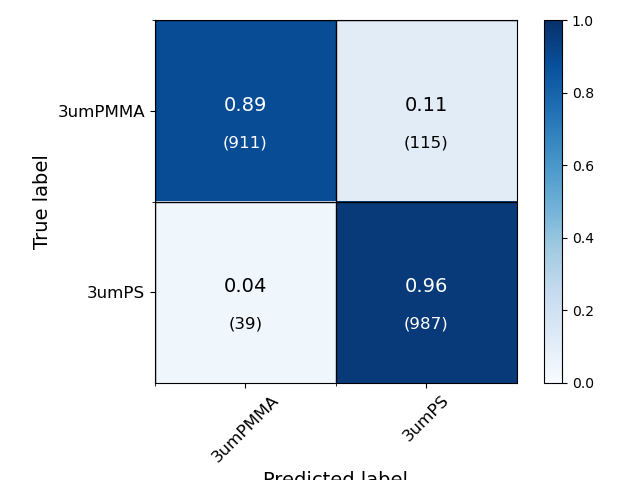

In [8]:
save_dir ="./pickle/displacement type 3um classification cross-validation results"
cf.save_results(save_dir, classes=np.unique(targets), accuracy=accuracy, loss=loss, val_accuracy=val_accuracy, 
                val_loss=val_loss, predictions=predictions, combinations=combinations,M=M, 
                k=k, epochs=epochs, bins=P, window=(position_x_lim,position_x_lim_zoom), npoints=npoints, dt=dt)

# $8\mu$ size particles

In [ ]:
remove = ["4umPS", "3umPMMA", "3umPS", "water"]  # particles to be removed from the set

data_type = 0  # 0 for position and 1 for displacement

targets, data = db.load_timeseries(exp_data_dir, npoints, remove, data_type)

X = np.zeros((data.shape[1], data.shape[2],2*P,P,1))

X[:,:,:P] = db.image_plotter(data,P=P, nplanes=1, xlim=position_x_lim, ylim=position_x_lim)
X[:,:,P:2*P] = db.image_plotter(data,P=P, nplanes=1, xlim=position_x_lim_zoom, ylim=position_x_lim_zoom)

In [ ]:
y = np.array([np.where(np.unique(targets)==targets[i])[0][0] for i in range(targets.shape[0])])

accuracy, loss, val_accuracy, val_loss, predictions, combinations = cf.markov_cycle(model, X=X, y=y, k=k, M=M)

In [ ]:
save_dir ="./pickle/displacement type 8um classification cross-validation results"
cf.save_results(save_dir, classes=np.unique(targets), accuracy=accuracy, loss=loss, val_accuracy=val_accuracy, 
                val_loss=val_loss, predictions=predictions, combinations=combinations,M=M, 
                k=k, epochs=epochs, bins=P, window=(position_x_lim,position_x_lim_zoom), npoints=npoints, dt=dt)